# T2.5.1

En este notebook se procederá a hacer un análisis de las métricas implementadas hasta al momento, y si es posible, se evaluarán más si se considera necesario.

In [1]:
# Importamos el módulo de métricas
import sys
sys.path.append('../../')
from image_metrics import ImageMetrics

### Fotos organizadas por categoría

Se cuenta con datos tomados por nosotros en el C

- **1-44:** Primera tanda de fotos.
- **45-63** Segunda tanda de fotos.
- **64-71:** Tercera tanda de fotos.
- **72-116:** Cuarta tanda de fotos.
- **117-174:** Sexta tanda de fotos.

Además se tomaron algunas fotos adicionales para ver el comportamiento de las métricas.

In [2]:
import os

base_path = 'C:\\Users\\xujiz\\Documents\\usm\\PDI\\Proyecto\\revive\\camera_module\\tests\\metrics_test\\'
all_data_dir = os.path.join(base_path, 'data')

# Lista de todas las rutas de imágenes en el directorio 'data'
image_paths = [os.path.join(all_data_dir, image) for image in os.listdir(all_data_dir) if image.endswith('.jpg')]
image_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

data1_paths = image_paths[0:44]
data2_paths = image_paths[44:63]
data3_paths = image_paths[63:71]
data4_paths = image_paths[71:116]
data5_paths = image_paths[116:174]

data_night_dir = os.path.join(base_path, 'data_night')
data_night_path = [os.path.join(data_night_dir, image) for image in os.listdir(data_night_dir) if image.endswith('.jpg')]   

In [3]:
data_1_44 = ImageMetrics.load_images(data1_paths) 
data_45_63 = ImageMetrics.load_images(data2_paths)
data_64_71 = ImageMetrics.load_images(data3_paths)
data_72_116 = ImageMetrics.load_images(data4_paths)
data_117_174 = ImageMetrics.load_images(data5_paths)
data_night = ImageMetrics.load_images(data_night_path)

In [4]:
# Definimos funciones para mostrar imágenes
import matplotlib.pyplot as plt
import cv2

SAVE_DPI = 300
def display_image(img, title="Image", save=False, save_name='image.png'):
    """Muestra la imagen usando matplotlib."""
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')  
    if save:
        plt.savefig('saved_images/' + save_name, dpi=SAVE_DPI)
    plt.show()

def display_images(images, titles=None, save=False, save_name='images.png'):
    """Muestra varias imágenes en una fila."""
    if titles is None:
        titles = ['Image' + str(i) for i in range(len(images))]
    
    plt.figure(figsize=(15, 15))
    
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i+1)
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title(titles[i])
        plt.axis('off')
    if save:
        plt.savefig('saved_images/' + save_name, dpi=SAVE_DPI)
    plt.show()


In [31]:
import pandas as pd

def evaluate_metrics_and_display_results(image_set, title="Resultados del Análisis:"):
    """Evalúa las métricas de una imagen y muestra los resultados."""
    metrics_to_evaluate = [ImageMetrics.brightness_metric, ImageMetrics.variance_of_laplacian, ImageMetrics.histogram_entropy,  ImageMetrics.image_contrast]
    results = {}
    for metric_func in metrics_to_evaluate:
        metric_name = metric_func.__name__ 
        results[metric_name] = ImageMetrics.analyze_image_set(image_set, file_path=False, metric_func=metric_func)
    display_results(results, title=title)

def display_metrics(metrics_dict, title="Métricas de Imágen:"):
    """Muestra las métricas en un DataFrame de pandas."""
    df_metrics = pd.DataFrame([metrics_dict])
    styled = df_metrics.style.set_caption(title)
    display(styled)

def display_results(results, title="Resultados del Análisis:"):
    """Estructura y muestra los resultados en un DataFrame."""
    # Crear un DataFrame vacío
    df = pd.DataFrame()

    for metric, values in results.items():
        for stat, value in values.items():
            if stat != "all_values": 
                df.at[stat, metric] = value
    display(df.style.set_caption(title))

In [6]:
# Hay feedback, asi que hay que recargar el modulo
from importlib import reload

reload(sys.modules['image_metrics'])

from image_metrics import ImageMetrics

En la tarea 2.3.1 se detallaron varias fuentes de errores que podrían generarse en la captura. En esta tarea se procederá a analizar las métricas para ver si se pueden detectar algunos de estos errores. Algunos de estos son:

- Oclusión
- Desenfoque
- Subexposición
- Sobreexposición

Para ello se procederá a analizar las métricas para algunas fotos que nos darán una idea de cómo se comportan las métricas en entornos normales.

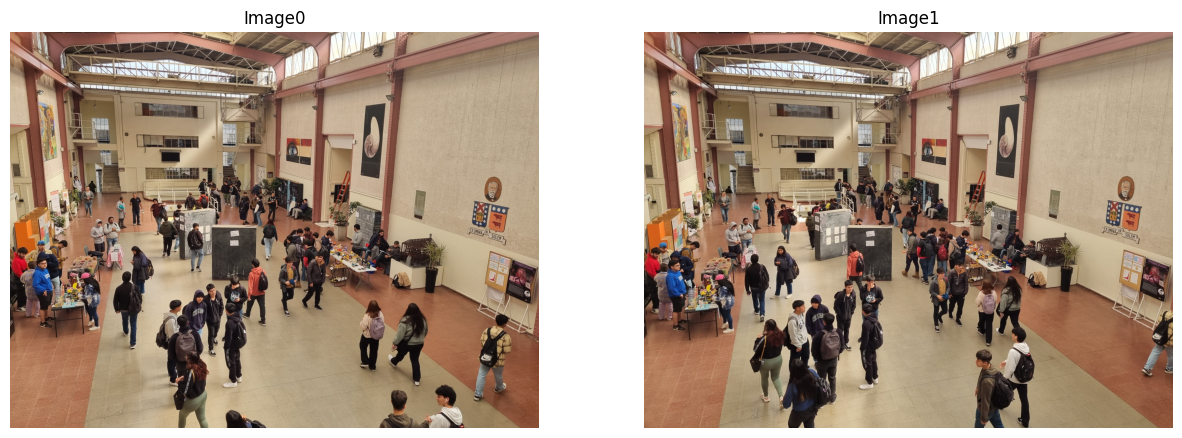

In [7]:
display_images(data_1_44[5:6+1])

In [8]:
image0 = data_1_44[5]
metrics_image0= ImageMetrics.get_metrics(image0, file_path=False)
display_metrics(metrics_image0)

In [9]:
image1 = data_1_44[6]
metrics_image1= ImageMetrics.get_metrics(image1, file_path=False)
display_metrics(metrics_image1)

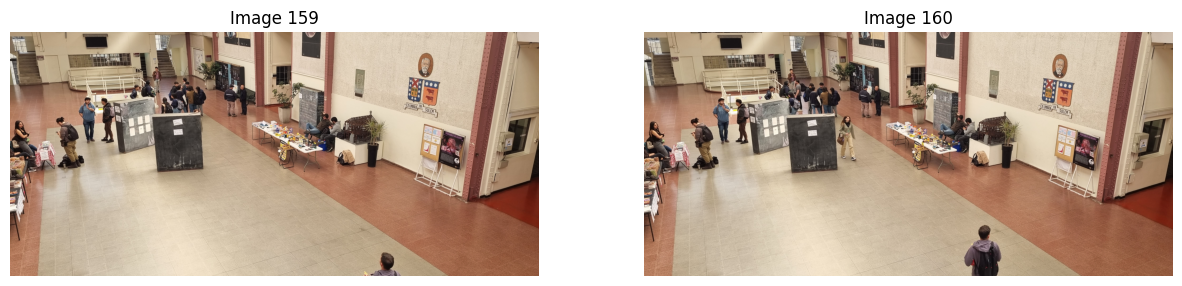

In [10]:
idx = 159-117
display_images(data_117_174[idx:idx+1+1], titles=['Image 159', 'Image 160'])

In [11]:
metrics_image159 = ImageMetrics.get_metrics(data_117_174[idx], file_path=False)
display_metrics(metrics_image159)

In [12]:
metrics_image160 = ImageMetrics.get_metrics(data_117_174[idx+1], file_path=False)
display_metrics(metrics_image160)

El brillo promedio está entre [128,151]. Visualmente las imágenes con menos personas son más brillantes. Por lo que, como primera conclusión, es importante comparar fotos sacadas más o menos en el mismo horario para evitar falsos positivos por diferencias en el brillo debido a la iluminación.

La varianza del laplaciano puede indicarnos el nivel de desenfoque de las fotos, un bajo valor de este indica un alto desenfoque en la fotografía. Se puede observar que ninguna de las fotos analizadas presenta desenfoque y están en un rango de valores([761, 906]).

La entropía puede indicarnos la variedad de intensidades de píxeles en la imagen. Es decir, una imagen tapada presentaría un valor bajo de entropía. En este caso las imagenes presentan en un rango aproximado de [7.55, 6.40], entre ellos muy similar.

El contraste refleja la diferencia de color que hace distinguible a los objetos en una imagen. En nuestro caso, queremos poder distinguir a las personas del fondo. Un valor alto indica imágenes con alto contraste. En este caso las imagenes presentan en un rango aproximado de [54.0, 55.8], entre ellos muy similar.

#### Oclusión de la camara
La oclusión de la camara puede afectar inmensamente la calidad del conteo. Es por ello que se hace importante poder detectar estas situaciones.

Se procederá entonces a analizar lo que ocurre con la oclusión:

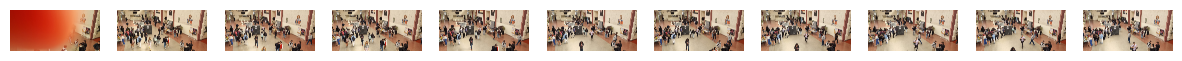

In [29]:
indices = [100, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112]
image_set = [data_72_116[idx-72] for idx in indices]
display_images(image_set, titles=['' for idx in indices])

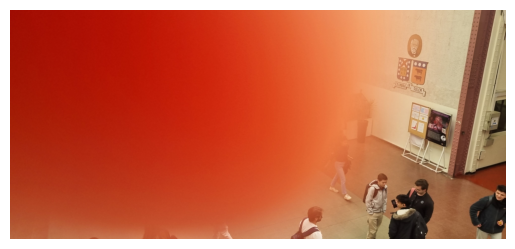

In [32]:
display_image(image_set[0], title="")
metrics_oclusion_image = ImageMetrics.get_metrics(image_set[0], file_path=False)
display_metrics(metrics_oclusion_image)

In [33]:
metrics_to_evaluate = [ImageMetrics.brightness_metric, ImageMetrics.variance_of_laplacian, ImageMetrics.histogram_entropy,  ImageMetrics.image_contrast]
results = {}
for metric_func in metrics_to_evaluate:
    metric_name = metric_func.__name__ 
    results[metric_name] = ImageMetrics.analyze_image_set(image_set, file_path=False, metric_func=metric_func)
display_results(results, title="Resultados del Análisis")

Podemos observar que la imagen tapada presenta todas las métricas por debajo de las 3 desviaciones estandares.

### Perturbaciones artificiales

Para enriquecer el análisis se procede a analizar situaciones donde se perturba la imagen.

In [90]:
# recargar modulo de perturbaciones
reload(sys.modules['image_perturbator'])
from image_perturbator import ImagePerturbator

#### Desenfoque

In [56]:
# Importamos un perturbador de imágenes para enriquecer el análisis
from image_perturbator import ImagePerturbator
# hacemos una copia profunda para no cargar las imágenes de nuevo
from copy import deepcopy
data_72_116_perturbed = deepcopy(data_72_116)

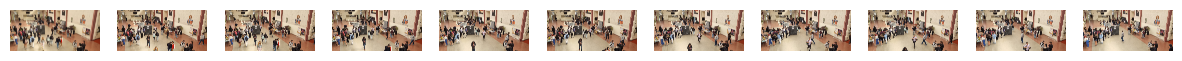

In [71]:
indices = [103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]
image_set = [data_72_116[idx-72] for idx in indices] 
normal_image = image_set[0]
image_set[0] = ImagePerturbator.blur(normal_image, kernel_size=(65,65))
display_images(image_set, titles=['' for idx in indices], save=True, save_name='set_con_un_blur.png')

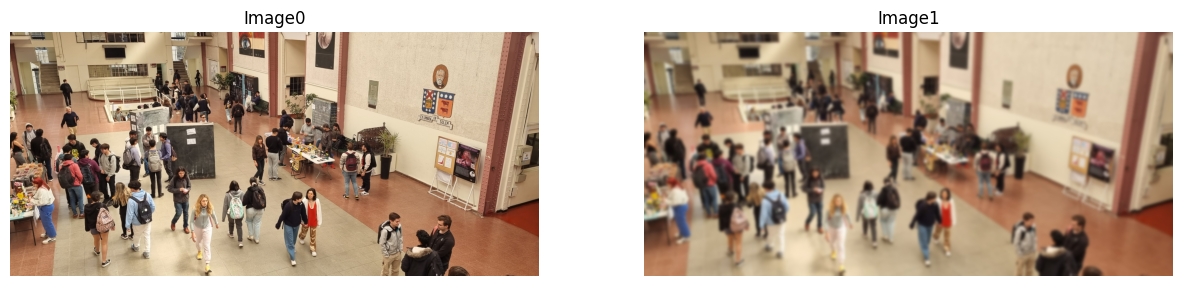

In [40]:
display_images([normal_image, image_set[0]])

In [41]:
metrics_image0 = ImageMetrics.get_metrics(normal_image, file_path=False)
display_metrics(metrics_image0 , title="Métricas de Imágen Normal")

In [42]:
metrics_image0_blur = ImageMetrics.get_metrics(image_set[0], file_path=False)
display_metrics(metrics_image0_blur, title="Métricas de Imágen con Blur")

In [43]:
evaluate_metrics_and_display_results(image_set)

La imagen desenfocada presenta aproximadamente el mismo brillo. Mientras que las otras 3 métricas tienen todos sus valores por debajo de las 3 desviaciones estandar

#### Subexposición

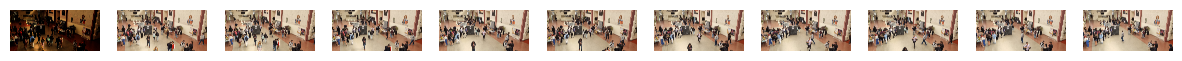

In [93]:
indices = [103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]
image_set = [data_72_116[idx-72] for idx in indices] 
normal_image = image_set[0]
image_set[0] = ImagePerturbator.darken(normal_image, gamma=0.2)
display_images(image_set, titles=['' for idx in indices])   

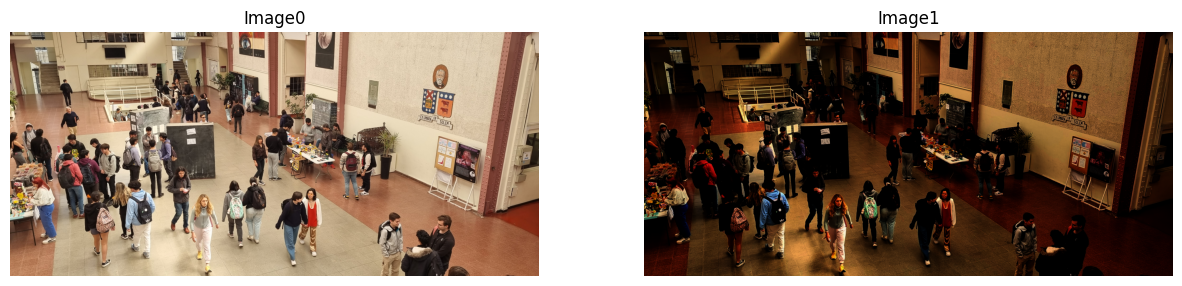

In [94]:
display_images([normal_image, image_set[0]])

In [95]:
display_metrics(metrics_image0 , title="Métricas de Imágen Normal")

In [96]:
metrics_image0_dark = ImageMetrics.get_metrics(image_set[0], file_path=False)
display_metrics(metrics_image0_dark, title="Métricas de Imágen oscurecida")

In [97]:
evaluate_metrics_and_display_results(image_set)

La imagen oscurecida presenta un brillo promedio, una entropy y un contraste por debajo de las 3 desviaciones estandar. Puede que la varianza del laplaciano haya aumentado por la forma en que se aplicó la subexposición.

#### Sobrexposición

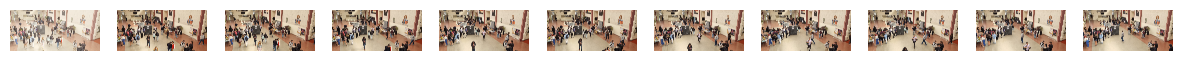

In [100]:
indices = [103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]
image_set = [data_72_116[idx-72] for idx in indices] 
normal_image = image_set[0]
image_set[0] = ImagePerturbator.brighten(normal_image, gamma=2.3)
display_images(image_set, titles=['' for idx in indices])   

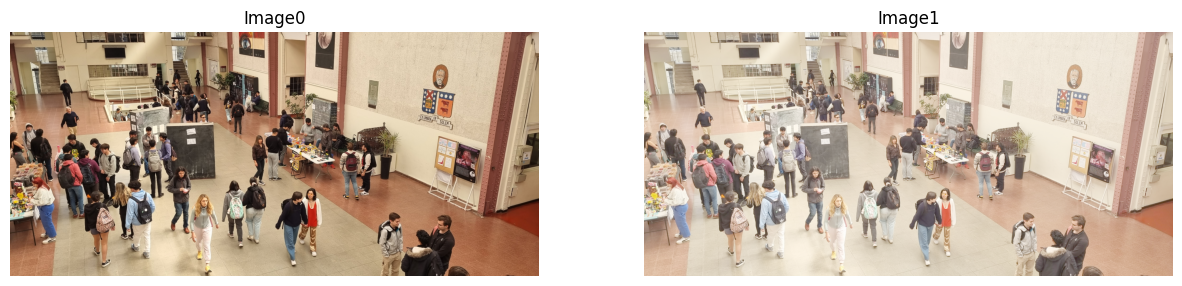

In [101]:
display_images([normal_image, image_set[0]])

In [102]:
display_metrics(metrics_image0 , title="Métricas de Imágen Normal")

In [103]:
metrics_image0_brightness = ImageMetrics.get_metrics(image_set[0], file_path=False)
display_metrics(metrics_image0_brightness, title="Métricas de Imágen Brillante")

In [104]:
evaluate_metrics_and_display_results(image_set)

La imagen sobreexpuesta presenta un brillo promedio, una entropia y un contraste por encima de las 3 desviaciones estandar. Mientras que la varianza del laplaciano se encuentra por debajo de las 3 desviaciones estandar.